In [2]:
import os
import re
import codecs
import pathlib

import flag
import country_converter as coco

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# import a clean function data
def clean_text(text):
    return text.strip()

## Task

- Split the main text.txt file into individual news report files, using the textID, the corresponding date and country for name of the news report file.
- Create country/year folders to push each file in its proper country/year.

In [4]:
# read in sources data
# data is separated by 1 or 2 tabs. 
sources = pd.read_csv("data/raw/sources.txt", 
                      sep="\t{1,2}", encoding="ISO-8859-1", skiprows=2, engine='python')

# rename columns
sources.columns = ["id", "n_words", "date", "country", "website", "url", "title"]

# date column -> pandas.DateTime
sources["date"] = pd.to_datetime(sources["date"], format="%y-%m-%d")

print(sources.shape)
sources.head()

(2960, 7)


,id,n_words,date,country,website,url,title
0,11241,397,2013-01-06,US,Kotaku,http://kotaku.com/5973495/author-of-the-warrio...,"Author of The Warriors, Cult Film Adapted to H..."
1,11242,757,2013-01-06,US,Michigan Radio,http://michiganradio.org/post/thats-what-they-...,That's What They Say: Dialect Society chooses ...
2,11243,755,2013-01-06,US,New York Daily News,http://www.nydailynews.com/life-style/eats/bes...,Best of New York: Croissant
3,11244,1677,2013-01-06,US,OregonLive.com,http://www.oregonlive.com/performance/index.ss...,Reflecting on a quarter-century of growth in P...
4,21242,794,2013-01-11,US,Ars Technica,http://arstechnica.com/gadgets/2013/01/ask-ars...,Ask Ars: Does Facebook auto-delete content aft...


In [13]:
# read in text data
# find lines that start with @@, extract id and text from them
with open("data/raw/text.txt", "r") as f:
    text = pd.DataFrame(
        [re.search("(\d+)\s(.*)", l[2:]).groups() for l in f.readlines() if l.startswith("@@")],
        columns=["id", "text"]
    )
    f.close()

# id should be an integer
text["id"] = text["id"].astype(int)

# clean text here
text["text"] = text["text"].apply(clean_text)
text['text'] = text.text.str.replace('<[^<]+?>', '')
text['text'] = text.text.str.replace("\n", '')
text['text'] = text.text.str.replace("@ @ @ @ @ @ @ @ @ @ ", '')
text['text'] = text.text.replace(" '", "'")
text['text'] = text.text.replace(" '", "'")
text['text'] = text.text.replace(" .", ".")
text['text'] = text.text.replace(" ,", ",")
text['text'] = text.text.replace("  ", "")
text['text'] = text.text.replace(" n't", "n't")
text["text"] = text["text"].apply(clean_text)
print(text.shape)
text.head()

(2914, 2)


,id,text
0,11241,"Sol Yurick , the writer whose 1965 novel "" The..."
1,11242,That 's What They Say : Dialect Society choose...
2,11243,A sublime croissant at French Tart in Grant Ci...
3,11244,Reflecting on a quarter-century of growth in P...
4,21242,Ask Ars : Does Facebook auto-delete content af...


In [22]:
# combine the data
reports = sources.merge(text, on="id", how="outer")
reports["year"] = reports["date"].dt.strftime("%Y")

In [34]:
#Total Articles per country with Flags
cc = coco.CountryConverter()
val_counts = reports.country.value_counts()

for country in [x for x in reports.country.unique().tolist() if str(x) != 'nan'] :
    if country:
        print(flag.flag(country), country, '| total counts: ',val_counts[country], ' | ', coco.convert(names=country, to='name_short'), )

🇺🇸 US | total counts:  396  |  United States
🇮🇪 IE | total counts:  278  |  Ireland
🇦🇺 AU | total counts:  147  |  Australia
🇬🇧 GB | total counts:  402  |  United Kingdom
🇨🇦 CA | total counts:  356  |  Canada
🇮🇳 IN | total counts:  388  |  India
🇳🇿 NZ | total counts:  126  |  New Zealand
🇿🇦 ZA | total counts:  197  |  South Africa
🇱🇰 LK | total counts:  16  |  Sri Lanka
🇸🇬 SG | total counts:  98  |  Singapore
🇵🇭 PH | total counts:  118  |  Philippines
🇬🇭 GH | total counts:  61  |  Ghana
🇳🇬 NG | total counts:  143  |  Nigeria
🇰🇪 KE | total counts:  33  |  Kenya
🇭🇰 HK | total counts:  6  |  Hong Kong
🇯🇲 JM | total counts:  15  |  Jamaica
🇵🇰 PK | total counts:  80  |  Pakistan
🇧🇩 BD | total counts:  21  |  Bangladesh
🇲🇾 MY | total counts:  73  |  Malaysia
🇹🇿 TZ | total counts:  6  |  Tanzania


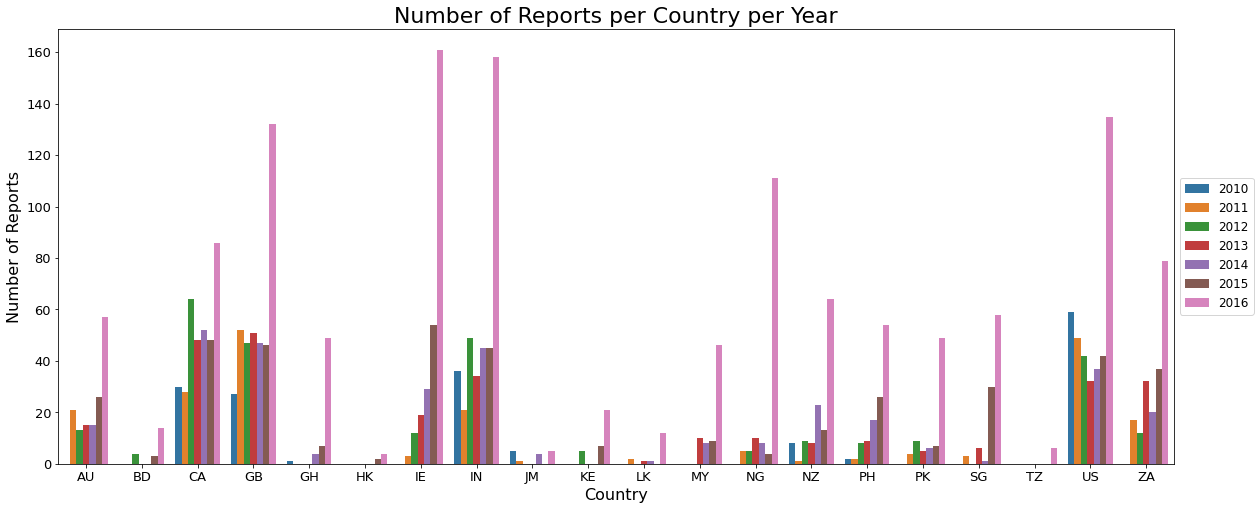

In [14]:
groups = reports.groupby(["country", "year"]).id.count().to_frame().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="id", 
    hue="year",
    data=groups,
    ax=ax
)

ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Reports", fontsize=16)
ax.set_title("Number of Reports per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

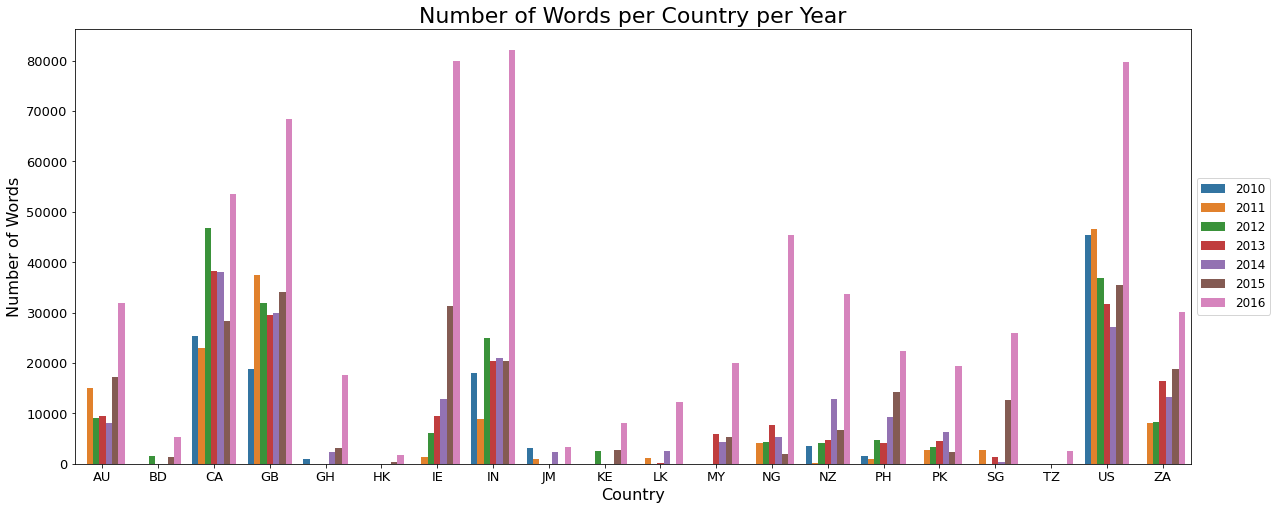

In [21]:
words_per_year = reports[['n_words','year','country']].groupby(['country','year']).sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 8))
sns.barplot(
    x="country", 
    y="n_words", 
    hue="year",
    data=words_per_year,
    ax=ax
)
ax.set_xlabel("Country", fontsize=16)
ax.set_ylabel("Number of Words", fontsize=16)
ax.set_title("Number of Words per Country per Year", fontsize=22)

ax.tick_params(axis='both', which='major', labelsize=13)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12);

Example, news report with textID 11241:
- pushed to a file with name 11241_US_13-01-06.txt. 
- 11241_US_13-01-06.txt should be in the US/2006 folder. 

In [15]:
def get_report_folder(report: pd.Series) -> str:
    """Get the folder a report belongs in as COUNTRY/YEAR"""
    if not pd.isna(report.date):
        year = report.date.strftime("%Y")
        return f"{report.country}/{year}"
    else:
        return f"{report.country}"

def get_report_name(report: pd.Series) -> str:
    """Get the file name for a report as ID_COUNTRY_DATE.txt"""
    if not pd.isna(report.date):
        date_string = report.date.strftime("%d-%m-%y")
        return f"{report.id}_{report.country}_{date_string}.txt"
    else:
        return f"{report.id}_{report.country}.txt"

def export_report(report: pd.Series, path=None) -> str:
    """Export a report to the correct folder with the correct name
    
    Keyword Arguments:
        path {str, optional}: a parent path to the folder. The directory you want the data all saved to.
        
    Returns:
        the output path FOLDER/FILE.txt, excluding the path argument.
    """
    folder = get_report_folder(report)
    file = get_report_name(report)
    
    full_path = f"{path + '/' if path else ''}{folder}"
    # create the folder, if it doesn't already exist
    pathlib.Path(full_path).mkdir(parents=True, exist_ok=True)
    
    # write the file
    with codecs.open(f"{full_path}/{file}", "w", "ISO-8859-1") as f:
        if not pd.isna(report.text):
            title = report.title if not pd.isna(report.title) else ""
            url = report.url if not pd.isna(report.url) else ""
            f.writelines([title, "\n", url, "\n\n", report.text])
        f.close()
    
    return f"{folder}/{file}"

In [16]:
reports["export_folder"] = reports.apply(export_report, axis=1, path="data/clean")

reports.to_csv("data/clean/all_reports.csv", index=False)
reports

,id,n_words,date,country,website,url,title,text,year,export_folder
0,11241,397.0,2013-01-06,US,Kotaku,http://kotaku.com/5973495/author-of-the-warrio...,"Author of The Warriors, Cult Film Adapted to H...","Sol Yurick , the writer whose 1965 novel "" The...",2013,US/2013/11241_US_06-01-13.txt
1,11242,757.0,2013-01-06,US,Michigan Radio,http://michiganradio.org/post/thats-what-they-...,That's What They Say: Dialect Society chooses ...,That 's What They Say : Dialect Society choose...,2013,US/2013/11242_US_06-01-13.txt
2,11243,755.0,2013-01-06,US,New York Daily News,http://www.nydailynews.com/life-style/eats/bes...,Best of New York: Croissant,A sublime croissant at French Tart in Grant Ci...,2013,US/2013/11243_US_06-01-13.txt
3,11244,1677.0,2013-01-06,US,OregonLive.com,http://www.oregonlive.com/performance/index.ss...,Reflecting on a quarter-century of growth in P...,Reflecting on a quarter-century of growth in P...,2013,US/2013/11244_US_06-01-13.txt
4,21242,794.0,2013-01-11,US,Ars Technica,http://arstechnica.com/gadgets/2013/01/ask-ars...,Ask Ars: Does Facebook auto-delete content aft...,Ask Ars : Does Facebook auto-delete content af...,2013,US/2013/21242_US_11-01-13.txt
...,...,...,...,...,...,...,...,...,...,...
3005,15031244,NaN,NaT,NaN,NaN,NaN,NaN,India continued to tear into Pakistan in the g...,NaT,nan/15031244_nan.txt
3006,15171241,NaN,NaT,NaN,NaN,NaN,NaN,President John Dramani Mahama has reminded his...,NaT,nan/15171241_nan.txt
3007,15171242,NaN,NaT,NaN,NaN,NaN,NaN,List of 23 NDC members expelled for going inde...,NaT,nan/15171242_nan.txt
3008,15171243,NaN,NaT,NaN,NaN,NaN,NaN,Messi should not captain Argentina - Passarell...,NaT,nan/15171243_nan.txt
